# Gaussian Mixture Model examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import os,sys,time

sys.path.insert(1, '../../src/')
import madmix
import madmix_aux
import gibbs
from concrete import *
import dequantization
import meanfield
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
fig_path='fig/'
fig_path='../../../madmix-tex/fig/'

In [2]:
def confusion_matrix(true,pred,K):
    """
    Create a confusion matrix when predicting N labels
    that can take K different values
    
    Inputs:
        true : (N,) array, true labels 
        pred : (N,) array, predicted labels
        K    : int, number of classes
    
    Outputs:
        mat : (K,K) array, confusion matrix
    """
    mat=np.zeros((K,K))
    for k1 in range(K):
        for k2 in range(K):
            mat[k1,k2]=np.logical_and(true==k1, pred==k2).sum()
        # end for
    # end for
    return mat

def permute_labels(pred,dim1,dim2,K):
    """
    Permute the dim1 and dim2 labels of pred
    
    Inputs:
        pred : (N,) array, predicted labels
        dim1 : int, first label to swap
        dim2 : int, second label to swap
        K    : int, number of classes
    
    Outputs:
        perm : (N,) array, permuted labels
    """
    perm=np.copy(pred)
    perm[perm==dim1]=K+1
    perm[perm==dim2]=dim1
    perm[perm==(K+1)]=dim2
    return perm


def gmm_lposterior(xd,w,mus,Sigmas,y,mu0,Sigma0,chol=None):
    """
    Evaluate the log posterior density of a GMM (given data y)
    
    Inputs:
        xd     : (N,B) array, labels (N = # of observations, B = Monte Carlo sample size)
        w      : (K,B) array, weights (K = # of clusters)
        mus    : (K,D,B) array, cluster means (D = dimension of observations)
        Sigmas : (K,D,D,B) array, cluster covariances
        y      : (N,D) array, observations
        mu0    : (K,D,B) array, prior cluster means 
        Sigma0 : (K,D,D,B) array, prior cluster covariances
    
    Outputs:
        lp     : (B,) array, posterior distribution log density up to normalizing constant
    """
    N=xd.shape[0]
    K,D,B=mus.shape
    chol=np.linalg.cholesky(np.moveaxis(Sigmas,3,1)) if chol is None else chol # (K,B,D,D)
    
    #lp = stats.dirichlet(np.ones(K)).logpdf(w) # prior weights
    lp = 0.6931471805599453*np.ones(B) # uninformative dirichlet value; prevents issues when sum(w)<1 but very close
    for k in range(K):
        std_mu = np.squeeze(np.matmul(chol[k,:,:,:],(mus[k,:,:]-mu0[k,:,None]).T[:,:,None]))
        lp += stats.invwishart(df=N/K,scale=Sigma0[k,:,:]*N/K).logpdf(Sigmas[k,:,:,:]) # prior Sigma
        lp += stats.multivariate_normal(mean=np.zeros(D),cov=np.eye(D)).logpdf(std_mu) # prior mu
    # end for
    
    for n in range(N): lp += np.log(w[xd[n,:].astype(int),np.arange(B)]) # prior labels
    
    for n in range(N):
        for k in range(K):
            std_y = np.squeeze(np.matmul(chol[k,:,:,:],(y[n,:,None]-mus[k,:,:]).T[:,:,None]))
            tmplp = stats.multivariate_normal(mean=np.zeros(D),cov=np.eye(D)).logpdf(std_y) # likelihood
            tmplp += np.log(w[k]) # likelihood
            
            idx = (xd[n,:]==k) # label n = cluster k
            ll  = np.zeros(B)
            ll[idx]=tmplp[idx]  # when xn=k, add gaussian lp
            lp += ll
        # end for
    # end for
    
    return lp

## Palmer penguin data set

In [145]:
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()
std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
K=3

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_85221/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_85221/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data


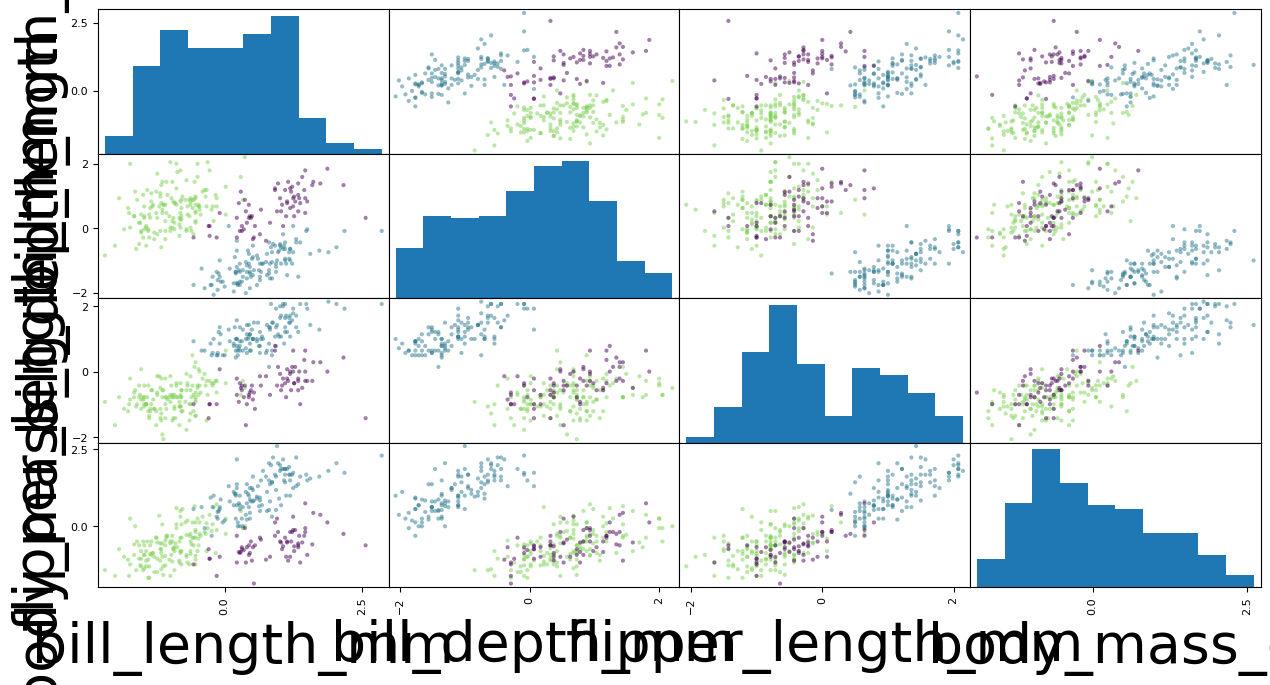

In [146]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[colors=='Adelie']='#7ad151'
colors[colors=='Gentoo']='#2a788e'
colors[colors=='Chinstrap']='#440154'
pd.plotting.scatter_matrix(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [147]:
pg_dat=np.array(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']])
pg_true=np.squeeze(np.array(penguins[['species']]))
pg_true[pg_true=='Adelie']=0
pg_true[pg_true=='Gentoo']=1
pg_true[pg_true=='Chinstrap']=2

In [148]:
N,D=pg_dat.shape
K=3

### Gibbs sampling

In [149]:
####################
####################
#      setup       #
####################
####################
gibbs_cput  =  np.inf*np.ones(2)

# settings
steps=1000
burnin_pct=0.9
D=pg_dat.shape[1]

# initial arrays
#mu0=np.array([[35.,25.,175.,3500.],  # green
#              [55.,17.,200.,4000.],  # purple 
#              [45.,10.,225.,5000.]]) # blue
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
for k in range(K): sigma0[k,:,:]=0.5*np.eye(D)
w0=np.ones(K)/K

In [284]:
####################
####################
#   run sampler    #
####################
####################
seed=1

t0=time.perf_counter()
xs,ws,mus,sigmas=gibbs.gibbs_gmm(y=pg_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)
gibbs_cput[0]=time.perf_counter()-t0

In [190]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(xs,'sockeye_run/penguin/pred_x')
aux.pkl_save(ws,'sockeye_run/penguin/pred_w')
aux.pkl_save(mus,'sockeye_run/penguin/pred_mu')
aux.pkl_save(sigmas,'sockeye_run/penguin/pred_sigma')

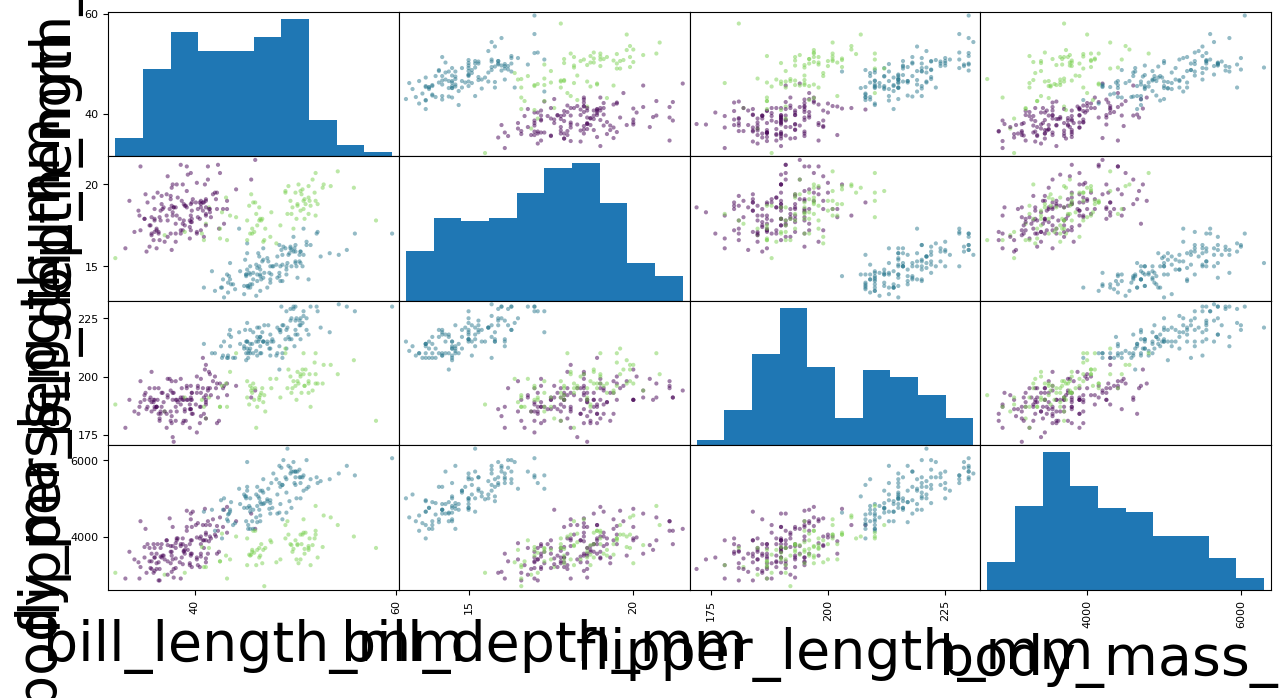

In [191]:
colors[xs[-1,:]==0]='#440154'
colors[xs[-1,:]==1]='#7ad151'
colors[xs[-1,:]==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [192]:
pred_x=xs.T
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T
gibbs_pred_pg=np.argmax(x_prbs,axis=1)

# account for label permutation
gibbs_pred_pg=permute_labels(gibbs_pred_pg,1,2,K)

In [193]:
confusion_matrix(pg_true,gibbs_pred_pg,K)

array([[144.,   0.,   2.],
       [  0., 119.,   0.],
       [  3.,   0.,  65.]])

### MAD Mix

In [20]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=10
steps=100
L=15
epsilon=0.001
xi=np.pi/16

# initial arrays
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=0.5*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/0.5
# end for
w0=np.ones(K)/K
nu0=1.

randq0=madmix_aux.gen_randq0(N,mu0,sigma0,invsigma0)
lq0=madmix_aux.gen_lq0(N,mu0,sigma0)
lp = madmix_aux.gmm_gen_lp(K,np.array(pg_dat))
gen_grad_lp=madmix_aux.gmm_gen_grad_lp(K,np.array(pg_dat))

In [195]:
RUN=True # to control whether to run or to import saved results
madmix_elbos = -np.inf*np.ones(2)

if RUN:
    madmix_cput  =  np.inf*np.ones(2)
    
    print('Sampling')
    t0=time.perf_counter()
    xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)
    madmix_cput[0]=time.perf_counter()-t0
    
    mad_pg_results=madmix_aux.madmix_gmm_pack(xd_,ud_,xc_,rho_,uc_)
    print('Done!')
    print('Saving sampling results')
    aux.pkl_save(mad_pg_results,'results/mad_pg_results')
    
    print('Evaluating log density')
    mad_lq_pg = madmix.lqN(xd_.astype(int),ud_,xc_,rho_,uc_,N,lq0,L,epsilon,lp,gen_grad_lp,xi)
    print('Done!')
    print('Saving log density results')
    aux.pkl_save(mad_lq_pg,'results/mad_pg_lq')
else:
    mad_pg_results=aux.pkl_load('results/mad_pg_results')
    mad_lq_pg=aux.pkl_load('results/mad_pg_lq')
    xd_,ud_,xc_,rho_,uc_=madmix_aux.madmix_gmm_unpack(mad_pg_results,N,K,D)
# end if

Sampling
Done!ing 100/100
Saving sampling results
Evaluating log density


/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/ham_mixflows.py:231: RuntimeWarning: divide by zero encountered in log1p
  def lap_Qm(p)  :     return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5))          #(M,d)->(M,d)
/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/madmix.py:56: RuntimeWarning: invalid value encountered in add
  w[n+1,:]=lq0(xd_,ud_,xc_,rho_,uc_)+tlJ # update weight


Done!
Saving log density results


In [196]:
ws_,mus_,Hs_=madmix_aux.madmix_gmm_unflatten(xc_,K,D)
ws_=ws_/np.sum(ws_,axis=0)[None,:]
Sigmas_=madmix_aux.HtoSigma(Hs_)

pred_x=np.copy(xd_)
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T
mad_pred_pg=np.argmax(x_prbs,axis=1)

In [197]:
# elbo computation
idx=np.logical_not(np.isnan(mad_lq_pg))
llp=gmm_lposterior(xd_[...,idx],ws_[...,idx],mus_[...,idx],Sigmas_[...,idx],pg_dat,mu0,sigma0)
madmix_elbos[0]=-np.mean(mad_lq_pg[idx]-llp)

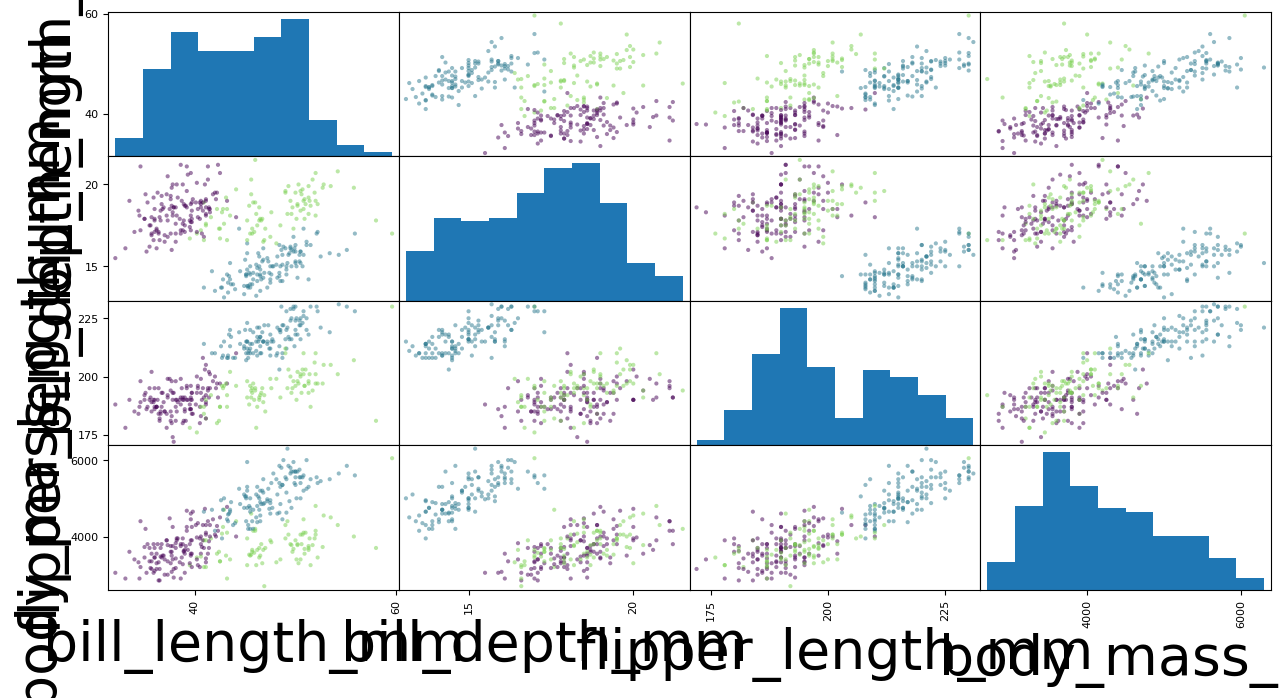

In [198]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[mad_pred_pg==0]='#440154'
colors[mad_pred_pg==1]='#7ad151'
colors[mad_pred_pg==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [199]:
# account for label permutation
mad_pred_pg=permute_labels(mad_pred_pg,1,2,K)

confusion_matrix(pg_true,mad_pred_pg,K)

array([[129.,   0.,  17.],
       [  0., 118.,   1.],
       [  0.,   0.,  68.]])

### Mean field

In [86]:
####################
####################
#      setup       #
####################
####################
meanfield_elbos = -np.inf*np.ones(2)
meanfield_cput  =  np.inf*np.ones(2)

K=3
y=pg_dat
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,4,4))
for k in range(K): sigma0[k,:,:]=1.*np.eye(4)
iterations=10000

In [201]:
####################
####################
#  run optimizer   #
####################
####################
t0=time.perf_counter()
alphas,lrs,ms,betas,invWs,nus=meanfield.meanfieldGMM(y,mu0,sigma0,iterations)
meanfield_cput[0]=time.perf_counter()-t0

In [202]:
# compute ELBO
meanfield_elbos[0]=meanfield.meanfield_gmm_elbo(10000,gmm_lposterior,alphas,lrs,ms,betas,invWs,nus,y,mu0,sigma0)

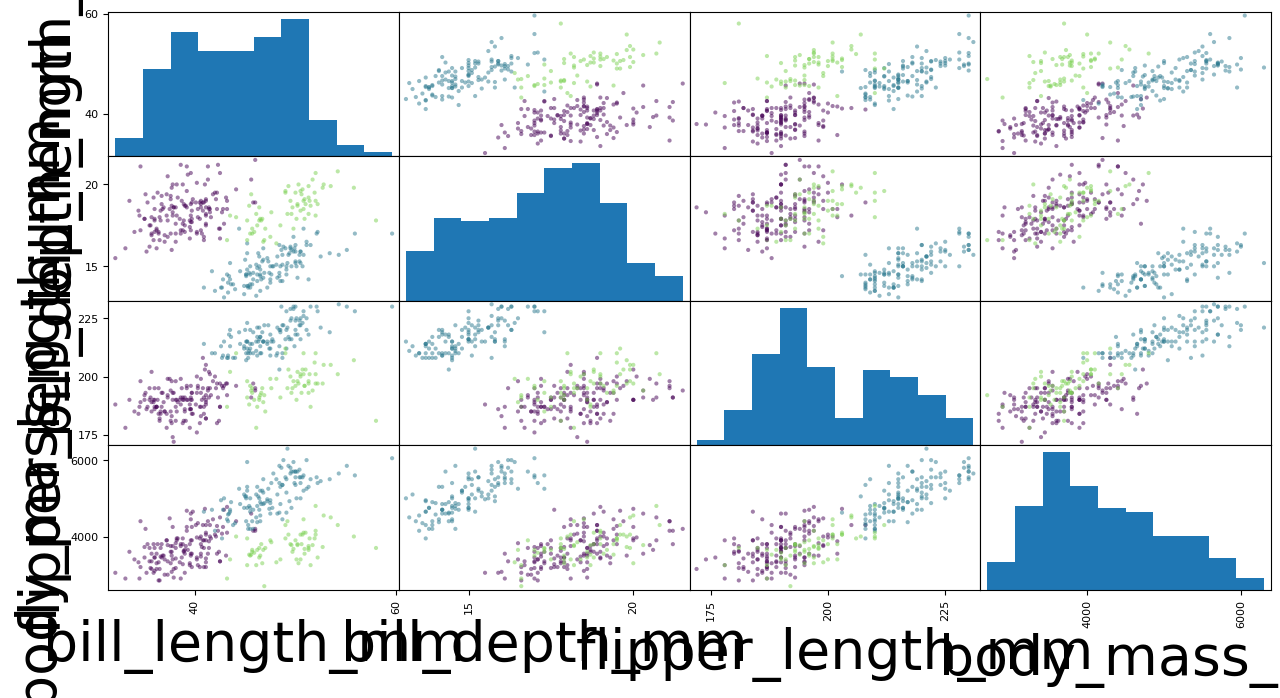

In [203]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[np.argmax(lrs,axis=1)==0]='#440154'
colors[np.argmax(lrs,axis=1)==1]='#7ad151'
colors[np.argmax(lrs,axis=1)==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [204]:
# account for label permutation
mf_pred_pg=np.argmax(lrs,axis=1)
mf_pred_pg=permute_labels(mf_pred_pg,1,2,K)


confusion_matrix(pg_true,mf_pred_pg,K)

array([[145.,   0.,   1.],
       [  0., 119.,   0.],
       [  5.,   0.,  63.]])

### Dequantization

In [8]:
########################
########################
#    dequantization    #
########################
########################
dequant_flows_pg     = aux.pkl_load('sockeye/dequantization/penguin/gmm_flows_dequant')
dequant_losses_pg    = aux.pkl_load('sockeye/dequantization/penguin/gmm_losses_dequant')
dequant_cpu_times_pg = aux.pkl_load('sockeye/dequantization/penguin/gmm_cpu_times_dequant')
dequant_densitycput  = np.zeros((2,len(dequant_flows_pg)))
dequant_sim_size_pg  = len(dequant_flows_pg)
dequant_max_iters_pg = dequant_losses_pg.shape[-1]
print('Total training time: '+str(dequant_cpu_times_pg.sum()/3600)+' hours')

Total training time: 23.63545961347247 hours


Text(0.5, 1.0, 'Dequantization RealNVP training loss traceplots')

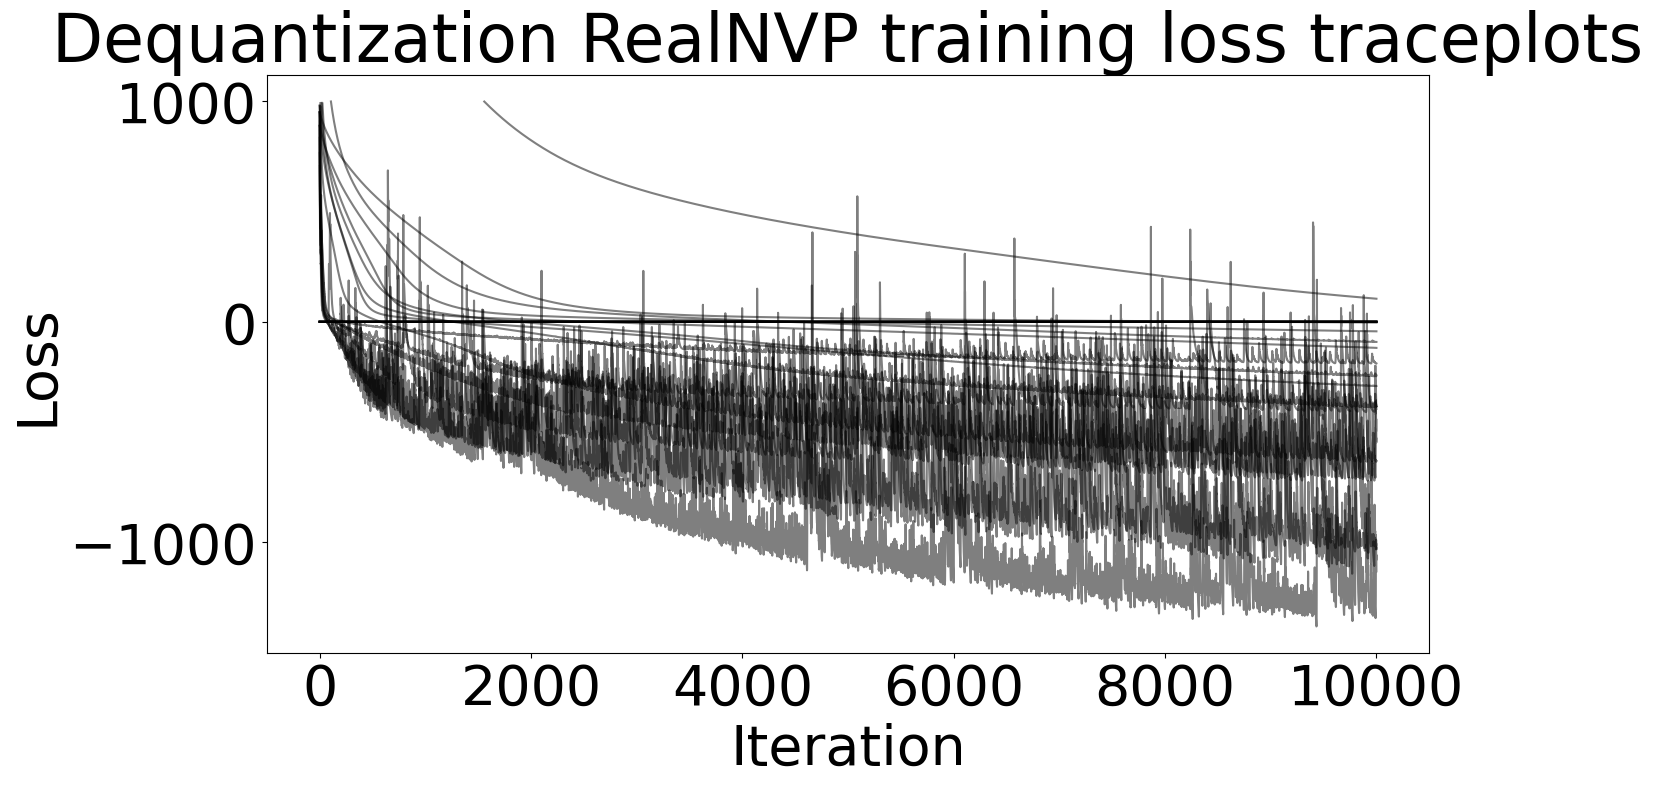

In [43]:
# loss traceplot
threshold=1000
for i in range(dequant_sim_size_pg): plt.plot(np.arange(dequant_max_iters_pg)[dequant_losses_pg[i,:]<threshold],dequant_losses_pg[i,dequant_losses_pg[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Dequantization RealNVP training loss traceplots')

In [20]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
Kpp=int(N+K+K*D+K*(D+D*(D-1)/2))
dequant_samples_pg=np.zeros((dequant_sim_size_pg,sample_size,Kpp))
dequant_densities_pg=np.zeros((dequant_sim_size_pg,sample_size))
dequant_elbos_pg=-np.inf*np.ones(dequant_sim_size_pg)

for i in range(dequant_sim_size_pg):
    print(str(i+1)+'/'+str(dequant_sim_size_pg),end='\r')
    tmp_flow=dequant_flows_pg[i]
    if isinstance(tmp_flow, int): continue
    
    try:
        # generate sample
        tmp_sample=tmp_flow.sample(sample_size)
        dequant_samples_pg[i,:,:] = tmp_sample.detach().numpy()
    
        # unpack and quantize sample
        xd_dequant_pg,ws_dequant_pg,mus_dequant_pg,Sigmas_dequant_pg=dequantization.dequant_gmm_unpack(tmp_sample,N,K,D)
        ws_dequant_pg = ws_dequant_pg.detach().numpy()
        ws_dequant_pg = np.exp(ws_dequant_pg)/np.sum(np.exp(ws_dequant_pg),axis=0)[None,:]
        mus_dequant_pg=mus_dequant_pg.detach().numpy()
        Sigmas_dequant_pg=Sigmas_dequant_pg.detach().numpy()
        xd_dequant_pg=np.floor(xd_dequant_pg).astype(int) # quantize
        xd_dequant_pg[xd_dequant_pg<0]=0
        xd_dequant_pg[xd_dequant_pg>K-1]=K-1
    
        # compute density
        t0=time.perf_counter()
        dequant_densities_pg[i,:]=tmp_flow.log_prob(tmp_sample).detach().numpy()
        dequant_densitycput[0,i]=time.perf_counter()-t0
    
        # estimate elbo
        llp = gmm_lposterior(xd_dequant_pg,ws_dequant_pg,mus_dequant_pg,Sigmas_dequant_pg,pg_dat,mu0,sigma0)
        dequant_elbos_pg[i]=-np.mean(np.ma.masked_invalid(dequant_densities_pg[i,:] - llp))
    except Exception: continue
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_85221/142346963.py:26: RuntimeWarning: overflow encountered in exp
  ws_dequant_pg = np.exp(ws_dequant_pg)/np.sum(np.exp(ws_dequant_pg),axis=0)[None,:]
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_85221/142346963.py:26: RuntimeWarning: invalid value encountered in divide
  ws_dequant_pg = np.exp(ws_dequant_pg)/np.sum(np.exp(ws_dequant_pg),axis=0)[None,:]


<Figure size 1500x750 with 0 Axes>

In [21]:
i_star=np.nanargmax(dequant_elbos_pg)
print('Optimal flow: '+str(i_star))

Optimal flow: 11


In [22]:
optimal_sample = dequant_flows_pg[i_star].sample(10000)
xd_dequant_pg,ws_dequant_pg,mus_dequant_pg,Sigmas_dequant_pg=dequantization.dequant_gmm_unpack(optimal_sample,N,K,D)
ws_dequant_pg=project_simplex_2d(ws_dequant_pg.T).detach().numpy().T
mus_dequant_pg=mus_dequant_pg.detach().numpy()
Sigmas_dequant_pg=Sigmas_dequant_pg.detach().numpy()
xd_dequant_pg=np.floor(xd_dequant_pg).astype(int) # quantize
xd_dequant_pg[xd_dequant_pg<0]=0
xd_dequant_pg[xd_dequant_pg>K-1]=K-1

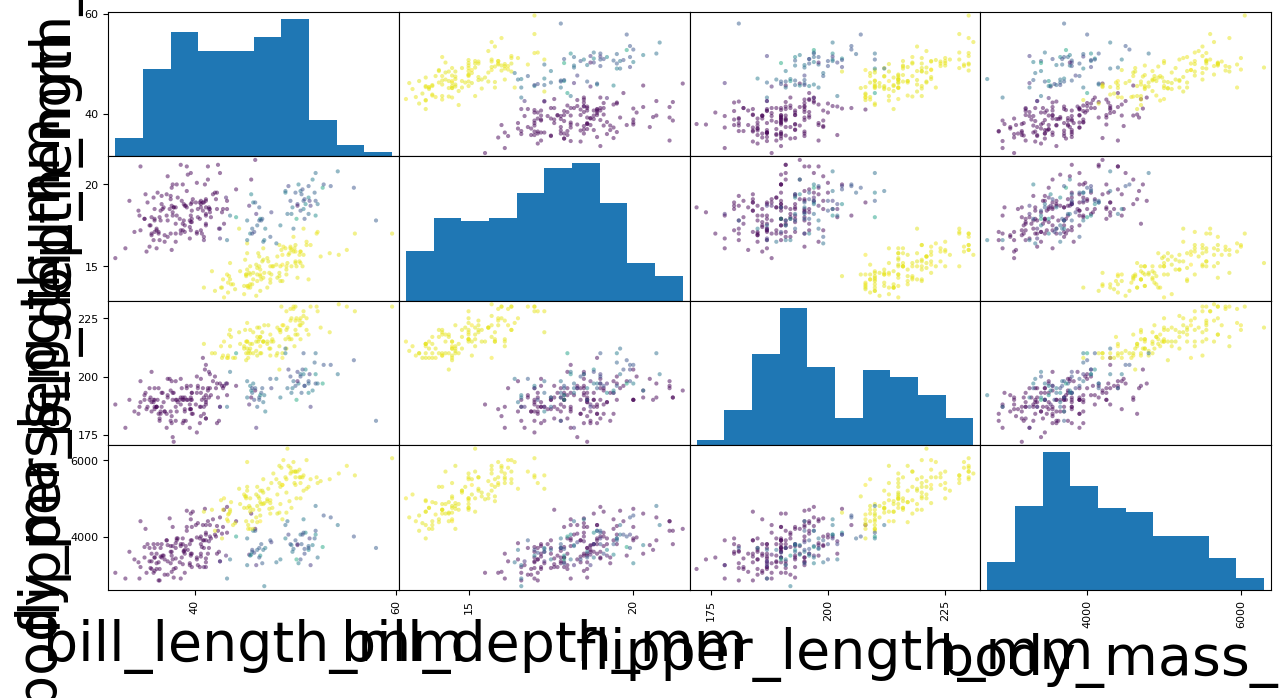

In [23]:
pg_cols = np.mean(xd_dequant_pg,axis=1)
colors[pg_cols==0]='#440154'
colors[pg_cols==1]='#7ad151'
colors[pg_cols==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=pg_cols);

### Concrete 

In [152]:
########################
########################
#       concrete       #
########################
########################
concrete_pg_flows     = aux.pkl_load('sockeye/penguin/gmm_flows')
concrete_pg_losses    = aux.pkl_load('sockeye/penguin/gmm_losses')
concrete_pg_cpu_times = aux.pkl_load('sockeye/penguin/gmm_cpu_times')
concrete_pg_densitycput  = np.zeros((2,len(concrete_pg_flows)))
concrete_pg_sim_size  = len(concrete_pg_flows)
concrete_pg_max_iters = concrete_pg_losses.shape[-1]
print('Total training time: '+str(concrete_pg_cpu_times.sum()/3600)+' hours')

Total training time: 52.39027351568448 hours


In [139]:
####################
####################
#    load data     #
####################
####################
path='sockeye/penguin/cache/'
files=os.listdir(path)
losses_files=[file[:-4] for file in files if 'losses' in file] # only get name without extension
flows_files=[file[:-4] for file in files if 'flows' in file]

concrete_pg_losses=np.zeros((len(losses_files),10001))
concrete_pg_flows=[None for i in range(len(losses_files))]
for i in range(len(losses_files)): 
    concrete_pg_losses[i]=aux.pkl_load(path+losses_files[i])
    concrete_pg_flows[i]=aux.pkl_load(path+flows_files[i])
# end for

# got from cache and output text files
concrete_pg_cput = np.array([6618.314439028036,5059.62303130200,4895.326881411951,4699.00335305091,9839.828872337937])

Text(0, 0.5, 'Loss')

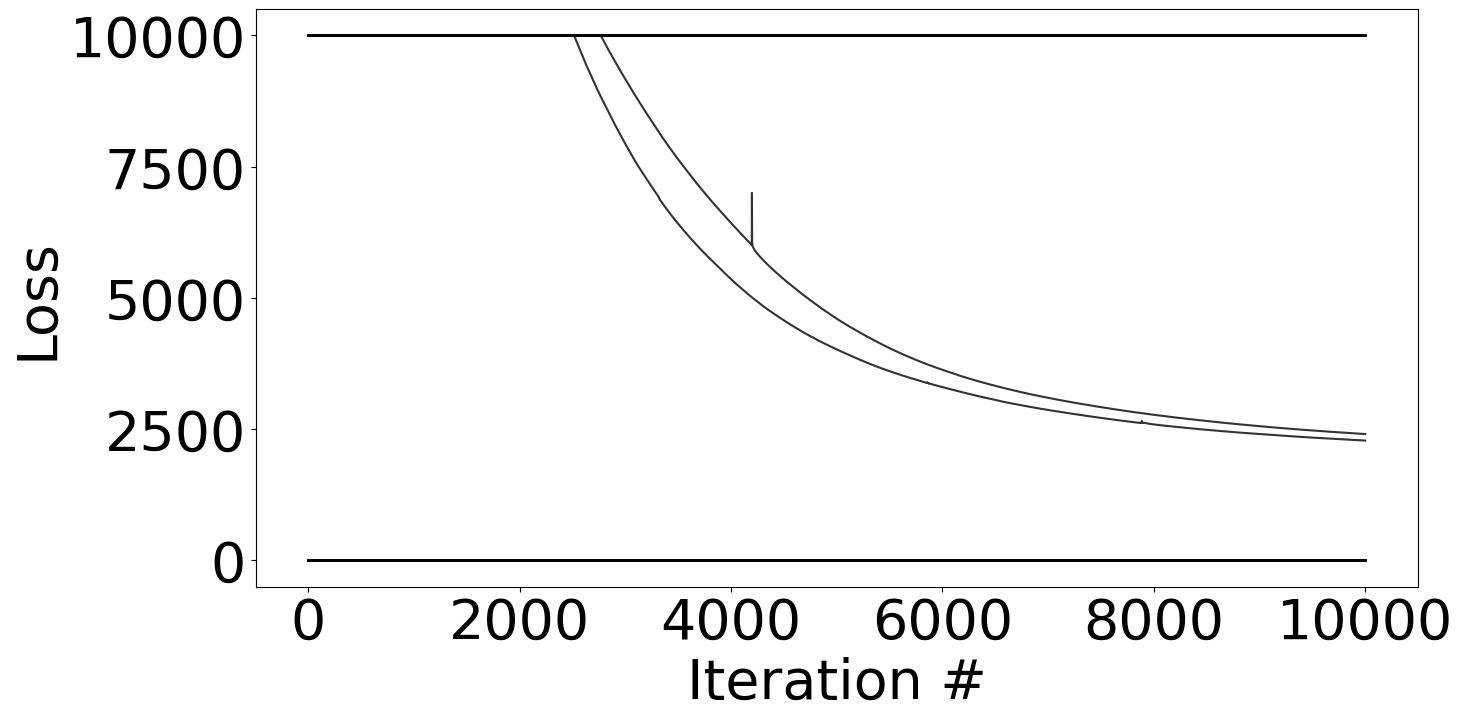

In [158]:
# loss traceplot
threshold=10000
plt_losses=np.copy(concrete_pg_losses)
plt_losses[plt_losses>threshold]=threshold
for i in range(len(losses_files)): plt.plot(np.arange(10001),plt_losses[i,:],c='black',alpha=0.8)
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [160]:
torch.manual_seed(1)
sample_size=1000
idx=np.diag_indices(D)

concrete_elbos_pg = -np.inf*np.ones(concrete_pg_sim_size)
concrete_densitycput_pg = np.inf*np.ones(concrete_pg_sim_size)

for i in range(concrete_pg_sim_size):
    print(str(i+1)+'/'+str(concrete_densitycput_pg),end='\r')
    
    tmp_flow = concrete_pg_flows[i]
    if isinstance(tmp_flow, int): continue
    
    tmp_sample=tmp_flow.sample(sample_size)
    xd_pg,ws_pg,mus_pg,Sigmas_pg=concrete_gmm_unpack(tmp_sample,N,K,D)
    ws_pg,mus_pg,Sigmas_pg=ws_pg.detach().numpy(),mus_pg.detach().numpy(),Sigmas_pg.detach().numpy()
    ws_pg-=aux.LogSumExp(ws_pg)
    ws_pg=np.exp(ws_pg)
    xd_labels=np.argmax(xd_pg,axis=1)
    idx = np.zeros(sample_size, dtype=bool)
    for j in range(sample_size):
        if np.sum(np.isinf(Sigmas_pg[:,:,:,j]))>0: continue
        idx[j] = True
    # end for
    
    try:
        t0 = time.perf_counter()
        llq = tmp_flow.log_prob(tmp_sample).detach().numpy()
        concrete_densitycput_pg[i] = time.perf_counter()-t0
        llp = gmm_lposterior(xd_labels[:,idx],ws_pg[:,idx],mus_pg[:,:,idx],Sigmas_pg[:,:,:,idx],pg_dat,mu0,sigma0,
                             chol=np.linalg.cholesky(np.moveaxis(Sigmas_pg[:,:,:,idx],3,1)))
        concrete_elbos_pg[i] = np.mean(llp-llq)
    except Exception:
        continue
    # end try

In [161]:
concrete_elbos_pg

array([            -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,

In [162]:
concrete_densitycput_pg

array([       inf, 0.39177829, 0.26750117,        inf, 0.27871829,
       0.281519  ,        inf, 0.33461854, 0.28033137,        inf,
       0.67385683, 0.77090708,        inf, 0.75920504, 0.550491  ,
              inf, 0.74315417, 0.59589442,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf, 0.33450313, 0.27484183, 0.23643479,
       0.426768  , 0.32472579,        inf, 0.36701558, 0.33344917,
              inf, 0.62220896, 0.54201767,        inf, 0.58608225,
       0.68343517,        inf, 0.98388367, 1.05095125,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf, 0.29956667, 0.25369

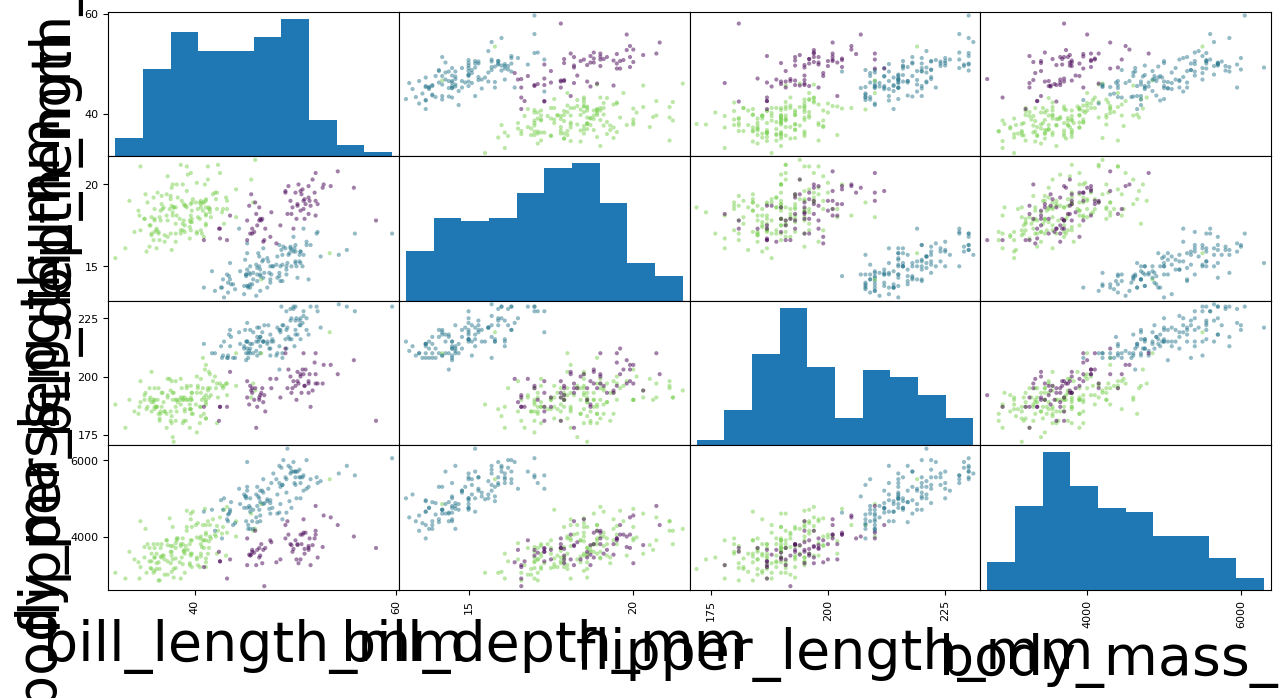

In [142]:
pg_cols = np.mean(xd_labels,axis=1)
colors[pg_cols==0]='#440154'
colors[pg_cols==1]='#7ad151'
colors[pg_cols==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

## Waveform data set

In [92]:
from sklearn.decomposition import PCA
waveform_dat=pd.read_table('https://hastie.su.domains/ElemStatLearn/datasets/waveform.train')
pca = PCA(n_components=4)
pca.fit(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])
waveform_pca=np.array(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])@pca.components_.T

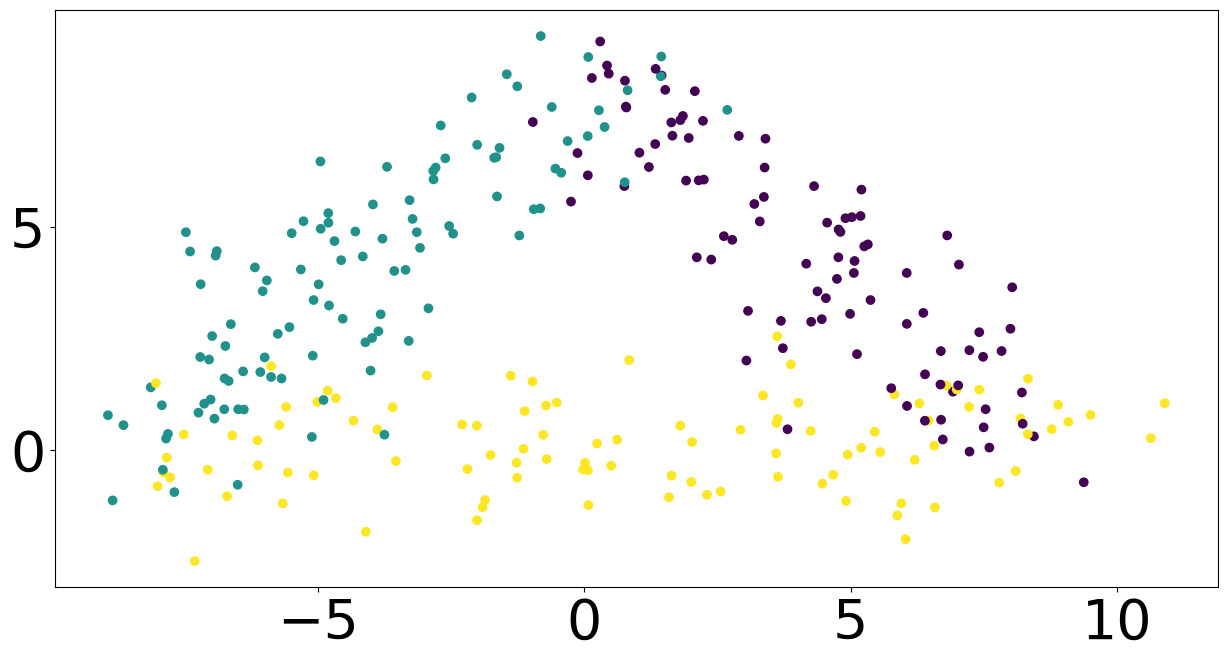

In [93]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.squeeze(np.array(waveform_dat[['y']])))

In [94]:
wf_true=np.squeeze(np.array(waveform_dat[['y']]))-1
wf_dat=waveform_pca[:,:2]
N,D=wf_dat.shape
K=3

### Gibbs sampling

In [95]:
####################
####################
#      setup       #
####################
####################

# settings
steps=1000
burnin_pct=0.9
D=wf_dat.shape[1]

# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,D,D))
for k in range(K): sigma0[k,:,:]=5.*np.eye(D)
w0=np.ones(K)/K

In [28]:
####################
####################
#   run sampler    #
####################
####################
seed=1

t0=time.perf_counter()
xs,ws,mus,sigmas=gibbs.gibbs_gmm(y=wf_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)
gibbs_cput[1]=time.perf_counter()-t0

In [210]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(xs,'sockeye_run/waveform/pred_x')
aux.pkl_save(ws,'sockeye_run/waveform/pred_w')
aux.pkl_save(mus,'sockeye_run/waveform/pred_mu')
aux.pkl_save(sigmas,'sockeye_run/waveform/pred_sigma')

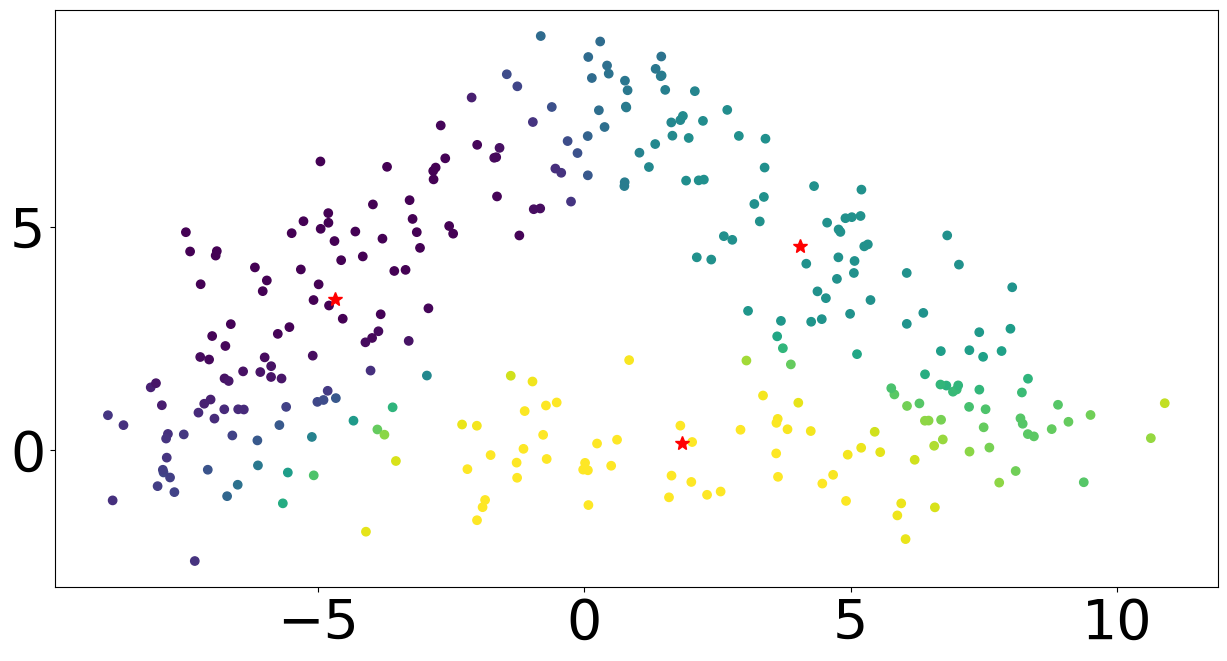

In [196]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.mean(xs,axis=0))
plt.plot(np.mean(mus,axis=0)[:,0],np.mean(mus,axis=0)[:,1],'*r',ms=10)


xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(np.mean(mus,axis=0)[k,:], np.mean(sigmas,axis=0)[k,:,:])
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [197]:
pred_x=xs.T
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T

In [198]:
# account for label permutation
gibbs_pred_wf=np.argmax(x_prbs,axis=1)
gibbs_pred_wf=permute_labels(gibbs_pred_wf,0,1,K)

confusion_matrix(wf_true,gibbs_pred_wf,K)

array([[82.,  3.,  9.],
       [10., 95.,  1.],
       [11., 19., 70.]])

### MAD Mix

In [214]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=10
steps=100
L=15
epsilon=0.001
xi=np.pi/16

# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=5.*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/5.
w0=np.ones(K)/K
nu0=1.

randq0=madmix_aux.gen_randq0(N,mu0,sigma0,invsigma0)
lq0=madmix_aux.gen_lq0(N,mu0,sigma0)
lp = madmix_aux.gmm_gen_lp(K,np.array(wf_dat))
gen_grad_lp=madmix_aux.gmm_gen_grad_lp(K,np.array(wf_dat))

In [215]:
RUN=True # to control whether to run or to import saved results

if RUN:
    print('Sampling')
    t0=time.perf_counter()
    xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)
    madmix_cput[1]=time.perf_counter()-t0
    
    mad_wf_results=madmix_aux.madmix_gmm_pack(xd_,ud_,xc_,rho_,uc_) 
    print('Done!')
    print('Saving sampling results')
    aux.pkl_save(mad_wf_results,'results/mad_wf_results')
    
    print('Evaluating log density')
    mad_lq_wf = madmix.lqN(xd_.astype(int),ud_,xc_,rho_,uc_,N,lq0,L,epsilon,lp,gen_grad_lp,xi)
    print('Done!')
    print('Saving log density results')
    aux.pkl_save(mad_lq_wf,'results/mad_wf_lq')
else:
    mad_wf_results=aux.pkl_load('results/mad_wf_results')
    mad_lq_wf=aux.pkl_load('results/mad_wf_lq')
    xd_,ud_,xc_,rho_,uc_=madmix_aux.madmix_gmm_unpack(mad_wf_results,N,K,D)
# end if

Sampling
Done!ing 100/100
Saving sampling results
Evaluating log density


/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/ham_mixflows.py:231: RuntimeWarning: divide by zero encountered in log1p
  def lap_Qm(p)  :     return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5))          #(M,d)->(M,d)
/Users/giankdiluvi/Library/CloudStorage/Dropbox/Documents/ubc/repos/madmix/madmix/examples/GMM/../../src/madmix.py:56: RuntimeWarning: invalid value encountered in add
  w[n+1,:]=lq0(xd_,ud_,xc_,rho_,uc_)+tlJ # update weight


Done!
Saving log density results


In [216]:
ws_,mus_,Hs_=madmix_aux.madmix_gmm_unflatten(xc_,K,D)
ws_=ws_/np.sum(ws_,axis=0)[None,:]
Sigmas_=madmix_aux.HtoSigma(Hs_)

pred_x=np.copy(xd_)
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T
mad_pred_wf=np.argmax(x_prbs,axis=1)

In [217]:
# elbo computation
idx=np.logical_not(np.isnan(mad_lq_wf))
llp=gmm_lposterior(xd_[...,idx],ws_[...,idx],mus_[...,idx],Sigmas_[...,idx],wf_dat,mu0,sigma0)
madmix_elbos[1]=-np.mean(mad_lq_wf[idx]-llp)

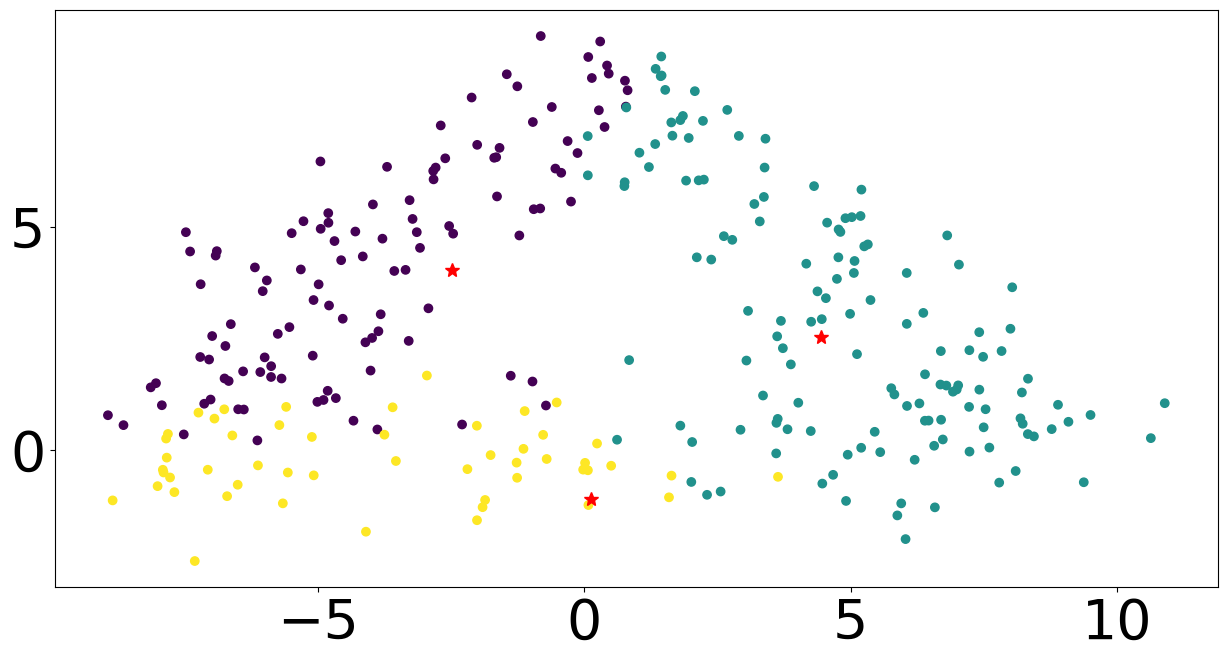

In [218]:
plt.scatter(wf_dat[:,0],wf_dat[:,1],c=mad_pred_wf)
plt.plot(np.mean(mus_,axis=-1)[:,0],np.mean(mus_,axis=-1)[:,1],'*r',ms=10)

xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(np.mean(mus_[k,:,:],axis=-1), np.mean(Sigmas_[k,...],axis=-1))
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [219]:
# account for label permutation
mad_pred_wf=permute_labels(mad_pred_wf,0,1,K)

confusion_matrix(wf_true,mad_pred_wf,K)

array([[85.,  9.,  0.],
       [ 5., 90., 11.],
       [47., 13., 40.]])

### Mean field

In [64]:
####################
####################
#      setup       #
####################
####################
K=3
y=wf_dat
# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,2,2))
for k in range(K): sigma0[k,:,:]=5.*np.eye(2)
iterations=10000

In [221]:
####################
####################
#  run optimizer   #
####################
####################
t0=time.perf_counter()
alphas,lrs,ms,betas,invWs,nus=meanfield.meanfieldGMM(y,mu0,sigma0,iterations)
meanfield_cput[1]=time.perf_counter()-t0

In [222]:
# compute ELBO
meanfield_elbos[1]=meanfield.meanfield_gmm_elbo(10000,gmm_lposterior,alphas,lrs,ms,betas,invWs,nus,y,mu0,sigma0)

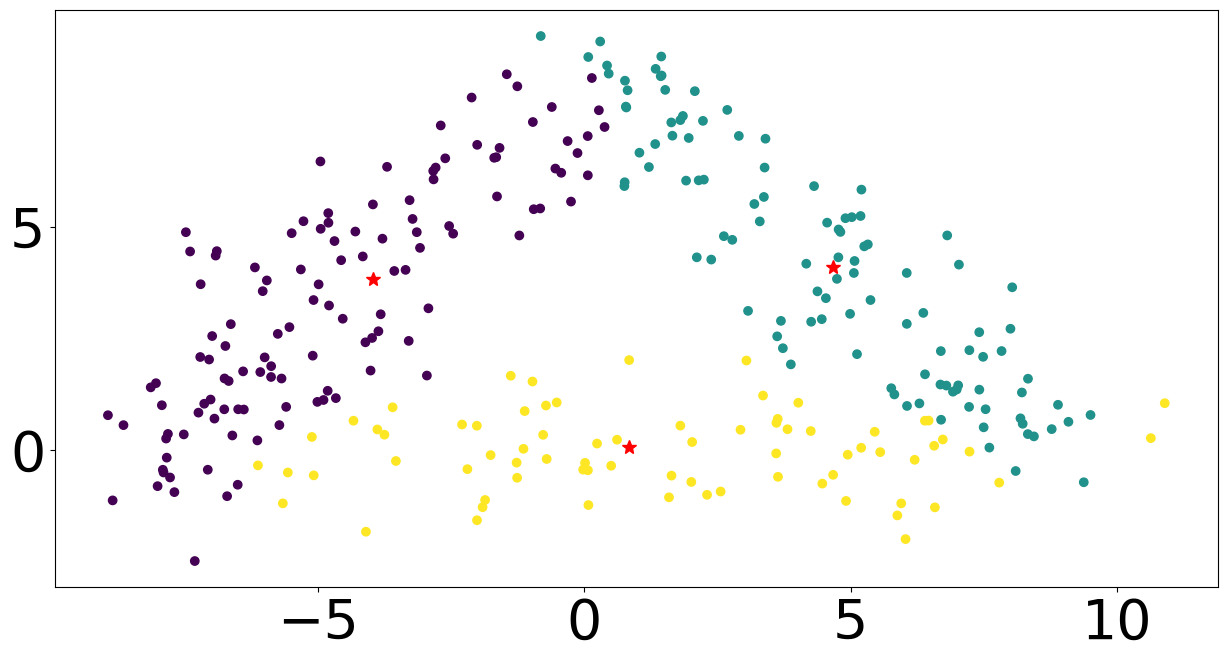

In [223]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.argmax(lrs,axis=1))
plt.plot(ms[:,0],ms[:,1],'*r',ms=10)

xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(ms[k,:], invWs[k,:,:]/nus[k])
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [224]:
# account for label permutation
mf_pred_wf=np.argmax(lrs,axis=1)
mf_pred_wf=permute_labels(mf_pred_wf,0,1,K)


confusion_matrix(wf_true,mf_pred_wf,K)

array([[84.,  5.,  5.],
       [ 7., 97.,  2.],
       [16., 18., 66.]])

### Dequantization

In [29]:
########################
########################
#    dequantization    #
########################
########################
dequant_flows_wf     = aux.pkl_load('sockeye/dequantization/waveform/gmm_flows_dequant')
dequant_losses_wf    = aux.pkl_load('sockeye/dequantization/waveform/gmm_losses_dequant')
dequant_cpu_times_wf = aux.pkl_load('sockeye/dequantization/waveform/gmm_cpu_times_dequant')
dequant_sim_size_wf  = len(dequant_flows_wf)
dequant_max_iters_wf = dequant_losses_wf.shape[-1]
print('Total training time: '+str(dequant_cpu_times_wf.sum()/3600)+' hours')

Total training time: 21.6506176440615 hours


Text(0.5, 1.0, 'Dequantization RealNVP training loss traceplots')

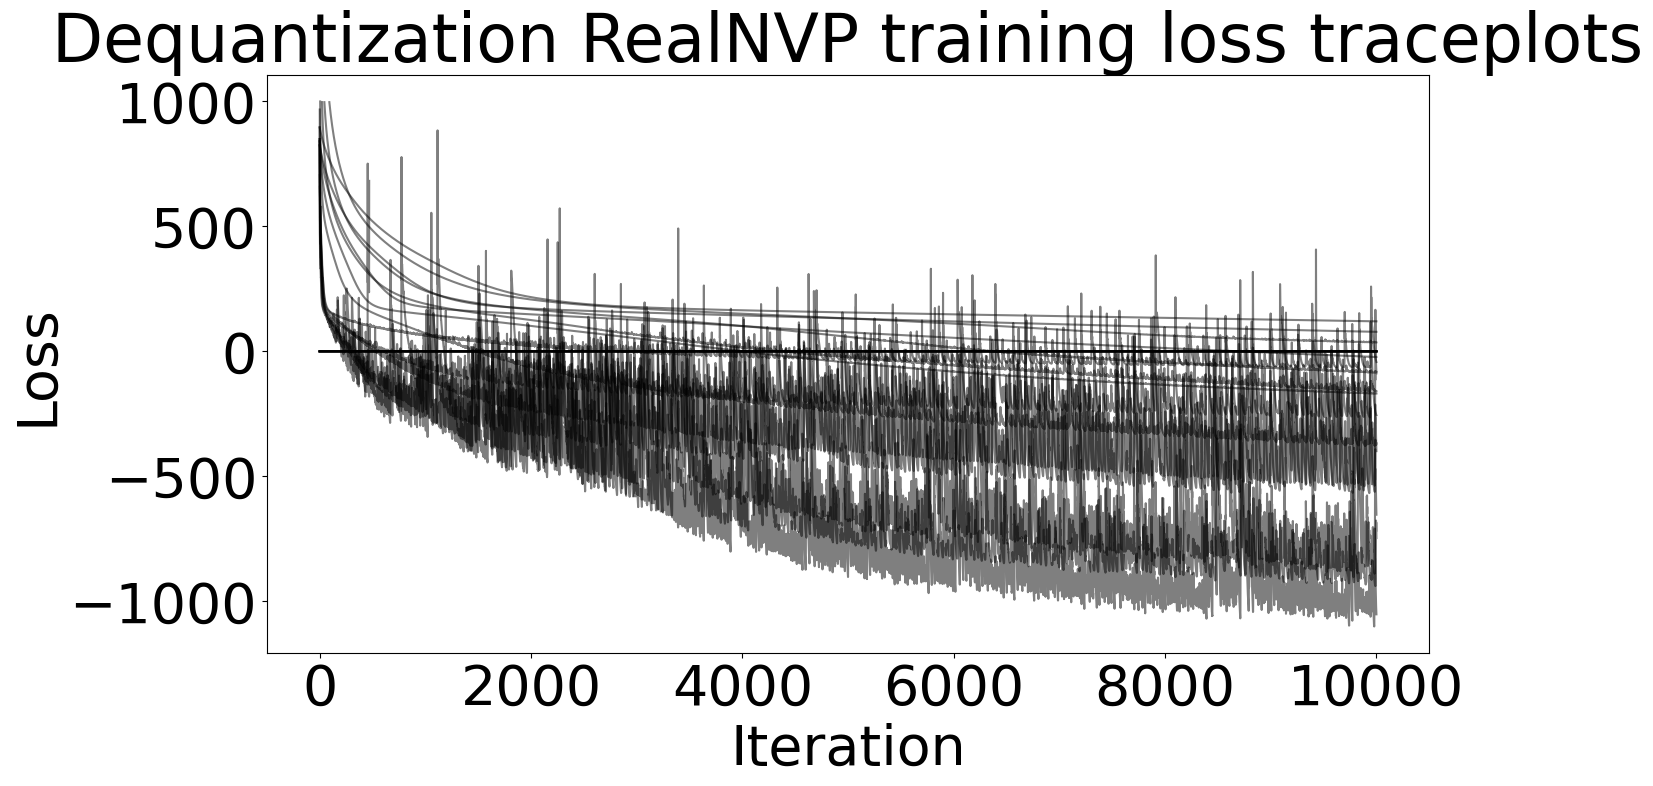

In [32]:
# loss traceplot
threshold=1000
for i in range(dequant_sim_size_wf): plt.plot(np.arange(dequant_max_iters_wf)[dequant_losses_wf[i,:]<threshold],dequant_losses_wf[i,dequant_losses_wf[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Dequantization RealNVP training loss traceplots')

In [33]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
Kpp=int(N+K+K*D+K*(D+D*(D-1)/2))
dequant_samples_wf=np.zeros((dequant_sim_size_wf,sample_size,Kpp))
dequant_densities_wf=np.zeros((dequant_sim_size_wf,sample_size))
dequant_elbos_wf=-np.inf*np.ones(dequant_sim_size_wf)

for i in range(dequant_sim_size_wf):
    print(str(i+1)+'/'+str(dequant_sim_size_wf),end='\r')
    tmp_flow=dequant_flows_wf[i]
    if isinstance(tmp_flow, int): continue
        
    try:
        # generate sample
        tmp_sample=tmp_flow.sample(sample_size)
        dequant_samples_wf[i,:,:] = tmp_sample.detach().numpy()
    
        # unpack and quantize sample
        xd_dequant_wf,ws_dequant_wf,mus_dequant_wf,Sigmas_dequant_wf=dequantization.dequant_gmm_unpack(tmp_sample,N,K,D)
        ws_dequant_wf=project_simplex_2d(ws_dequant_wf.T).detach().numpy().T
        mus_dequant_wf=mus_dequant_wf.detach().numpy()
        Sigmas_dequant_wf=Sigmas_dequant_wf.detach().numpy()
        xd_dequant_wf=np.floor(xd_dequant_wf).astype(int) # quantize
        xd_dequant_wf[xd_dequant_wf<0]=0
        xd_dequant_wf[xd_dequant_wf>K-1]=K-1
    
        # compute density
        t0=time.perf_counter()
        dequant_densities_wf[i,:]=tmp_flow.log_prob(tmp_sample).detach().numpy()
        dequant_densitycput[1,i]=time.perf_counter()-t0
    
        # estimate elbo
        llp = gmm_lposterior(xd_dequant_wf,ws_dequant_wf,mus_dequant_wf,Sigmas_dequant_wf,wf_dat,mu0,sigma0)
        dequant_elbos_wf[i]=-np.mean(np.ma.masked_invalid(dequant_densities_wf[i,:] - llp))
    except Exception: continue
# end for
plt.clf()

<Figure size 1500x750 with 0 Axes>

In [34]:
i_star=np.nanargmax(dequant_elbos_wf)
print('Optimal flow: '+str(i_star))

Optimal flow: 20


In [35]:
optimal_sample = dequant_flows_wf[i_star].sample(10000)
xd_dequant_wf,ws_dequant_wf,mus_dequant_wf,Sigmas_dequant_wf=dequantization.dequant_gmm_unpack(optimal_sample,N,K,D)
ws_dequant_wf=project_simplex_2d(ws_dequant_wf.T).detach().numpy().T
mus_dequant_wf=mus_dequant_wf.detach().numpy()
Sigmas_dequant_wf=Sigmas_dequant_wf.detach().numpy()
xd_dequant_wf=np.floor(xd_dequant_wf).astype(int) # quantize
xd_dequant_wf[xd_dequant_wf<0]=0
xd_dequant_wf[xd_dequant_wf>K-1]=K-1

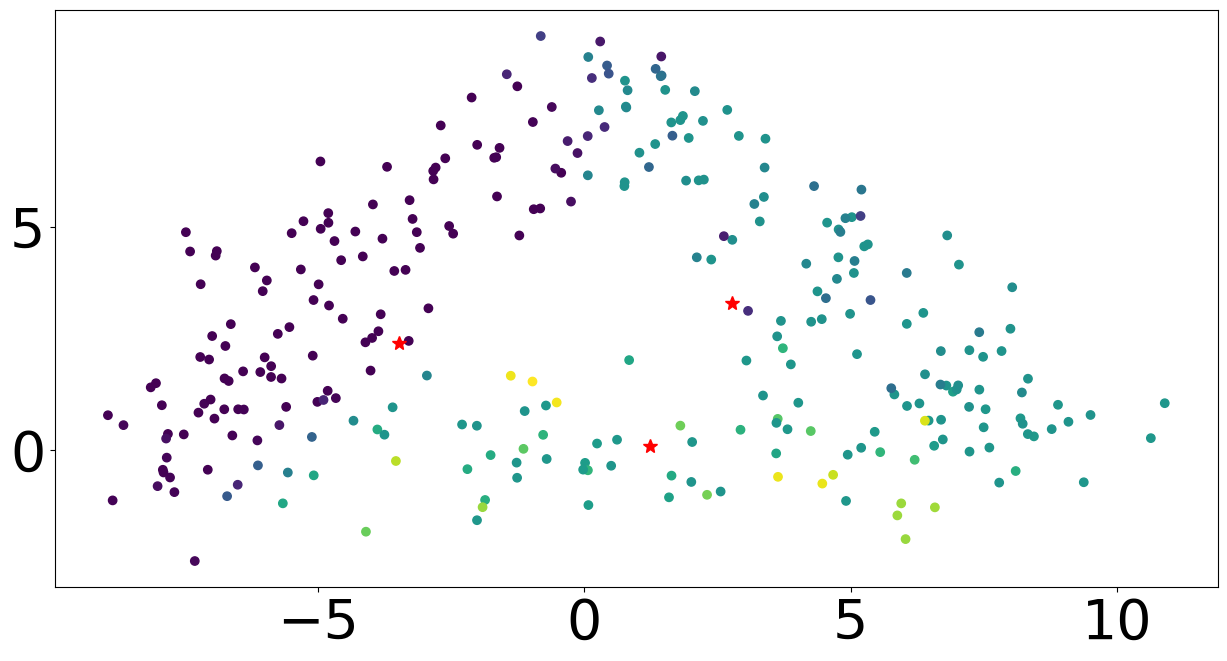

In [39]:
plt.scatter(wf_dat[:,0],wf_dat[:,1],c=np.mean(xd_dequant_wf,axis=1))
plt.plot(np.mean(mus_dequant_wf,axis=-1)[:,0],np.mean(mus_dequant_wf,axis=-1)[:,1],'*r',ms=10)

xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(np.mean(mus_dequant_wf,axis=-1)[k,:], np.mean(Sigmas_dequant_wf,axis=-1)[k,:,:])
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=4,colors='grey')

### Concrete

In [199]:
####################
####################
#    load data     #
####################
####################
path='sockeye/waveform/cache/'
files=os.listdir(path)
losses_files=[file[:-4] for file in files if 'losses' in file] # only get name without extension
flows_files=[file[:-4] for file in files if 'flows' in file]

concrete_wf_losses=np.zeros((len(losses_files),10001))
concrete_wf_flows=[None for i in range(len(losses_files))]
for i in range(len(losses_files)): 
    concrete_wf_losses[i]=aux.pkl_load(path+losses_files[i])
    concrete_wf_flows[i]=aux.pkl_load(path+flows_files[i])
# end for

# got from cache and output text files
concrete_wf_cput = np.array([4519.023812302039,4992.13403178798,3862.350781198009,
                            4505.757341608056,4871.528694076929,4883.2353827030165,
                            9044.814667066094,5680.082381324028,6533.77610979008])

In [80]:
########################
########################
#       concrete       #
########################
########################
concrete_wf_flows     = aux.pkl_load('sockeye/waveform/gmm_flows')
concrete_wf_losses    = aux.pkl_load('sockeye/waveform/gmm_losses')
concrete_wf_cpu_times = aux.pkl_load('sockeye/waveform/gmm_cpu_times')
concrete_wf_densitycput  = np.zeros((2,len(concrete_wf_flows)))
concrete_wf_sim_size  = len(concrete_wf_flows)
concrete_wf_max_iters = concrete_wf_losses.shape[-1]
print('Total training time: '+str(concrete_wf_cpu_times.sum()/3600)+' hours')

Total training time: 55.28359869872325 hours


Text(0, 0.5, 'Loss')

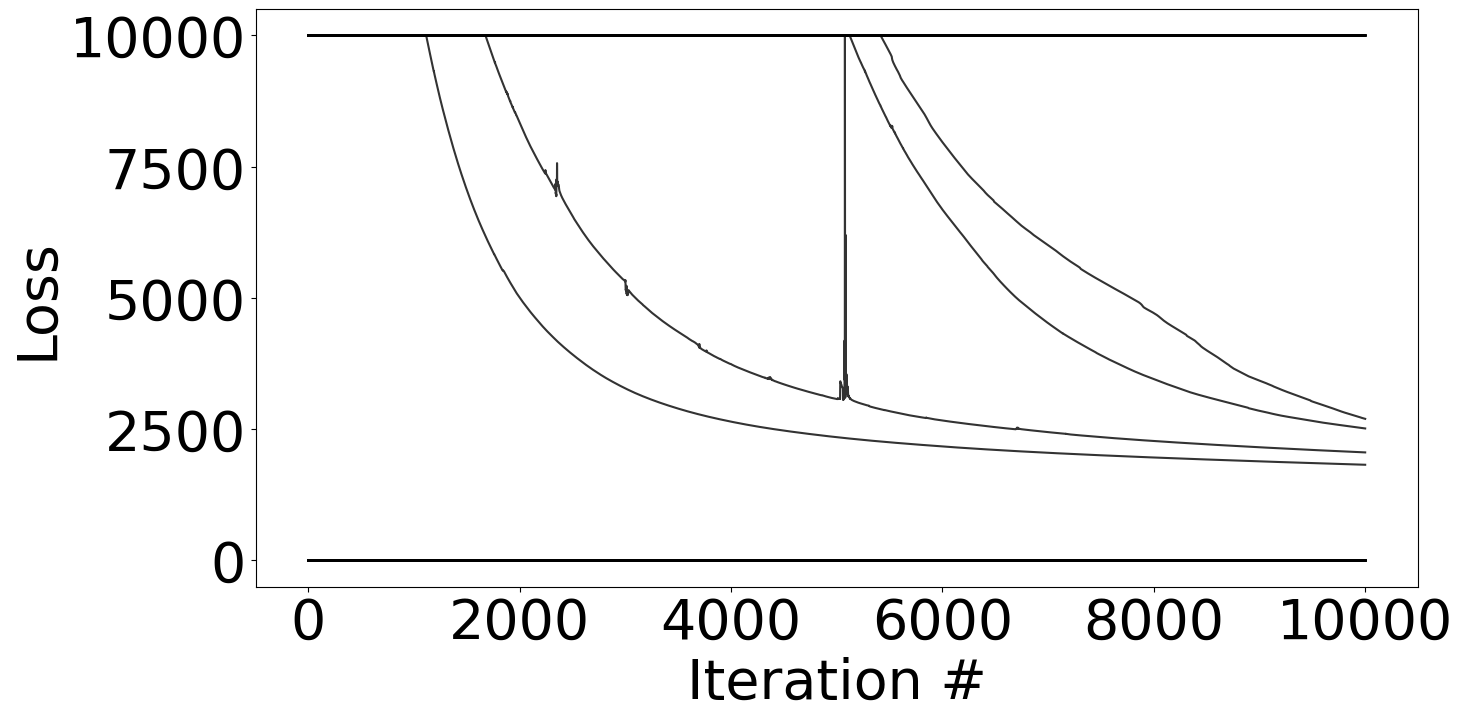

In [91]:
# loss traceplot
threshold=10000
plt_losses=np.copy(concrete_wf_losses)
plt_losses[plt_losses>threshold]=threshold
for i in range(len(losses_files)): plt.plot(np.arange(10001),plt_losses[i,:],c='black',alpha=0.8)
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [130]:
torch.manual_seed(1)
sample_size=1000
idx=np.diag_indices(D)

concrete_elbos_wf = -np.inf*np.ones(concrete_wf_sim_size)
concrete_densitycput_wf = np.inf*np.ones(concrete_wf_sim_size)

for i in range(concrete_wf_sim_size):
    print(str(i+1)+'/'+str(concrete_wf_sim_size),end='\r')
    
    tmp_flow = concrete_wf_flows[i]
    if isinstance(tmp_flow, int): continue
    
    tmp_sample=tmp_flow.sample(sample_size)
    xd_wf,ws_wf,mus_wf,Sigmas_wf=concrete_gmm_unpack(tmp_sample,N,K,D)
    ws_wf,mus_wf,Sigmas_wf=ws_wf.detach().numpy(),mus_wf.detach().numpy(),Sigmas_wf.detach().numpy()
    ws_wf=np.exp(ws_wf)/np.sum(np.exp(ws_wf),axis=0)
    xd_labels=np.argmax(xd_pg,axis=1)
    idx = np.zeros(sample_size, dtype=bool)
    for j in range(sample_size):
        if np.sum(np.isinf(Sigmas_pg[:,:,:,j]))>0: continue
        idx[j] = True
    # end for
    
    try:
        t0 = time.perf_counter()
        llq = tmp_flow.log_prob(tmp_sample).detach().numpy()
        concrete_densitycput_wf[i] = time.perf_counter()-t0
        llp = gmm_lposterior(xd_labels[:,idx],ws_pg[:,idx],mus_pg[:,:,idx],Sigmas_pg[:,:,:,idx],wf_dat,mu0,sigma0,
                             chol=np.linalg.cholesky(np.moveaxis(Sigmas_pg[:,:,:,idx],3,1)))
        concrete_elbos_wf[i] = np.mean(llp-llq)
    except Exception:
        continue
    # end try

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_85221/1016380119.py:17: RuntimeWarning: overflow encountered in exp
  ws_wf=np.exp(ws_wf)/np.sum(np.exp(ws_wf),axis=0)
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_85221/1016380119.py:17: RuntimeWarning: invalid value encountered in divide
  ws_wf=np.exp(ws_wf)/np.sum(np.exp(ws_wf),axis=0)


All are infinite!

In [131]:
concrete_elbos_wf

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf])

In [132]:
concrete_densitycput_wf

array([       inf, 0.25208379, 0.20686479, 0.18034088, 0.23667412,
       0.21134238,        inf, 0.23487517, 0.22910817,        inf,
       0.46458437, 0.38651879,        inf, 0.55369767, 0.44957225,
              inf, 0.44368437,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf, 0.22258025, 0.22685292, 0.17708896,
       0.25558013, 0.22455717,        inf, 0.24530058, 0.24559121,
              inf, 0.41246137, 0.36010533,        inf, 0.40201142,
       0.36997425,        inf, 0.43139971, 0.39701775,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf, 0.19965717,        

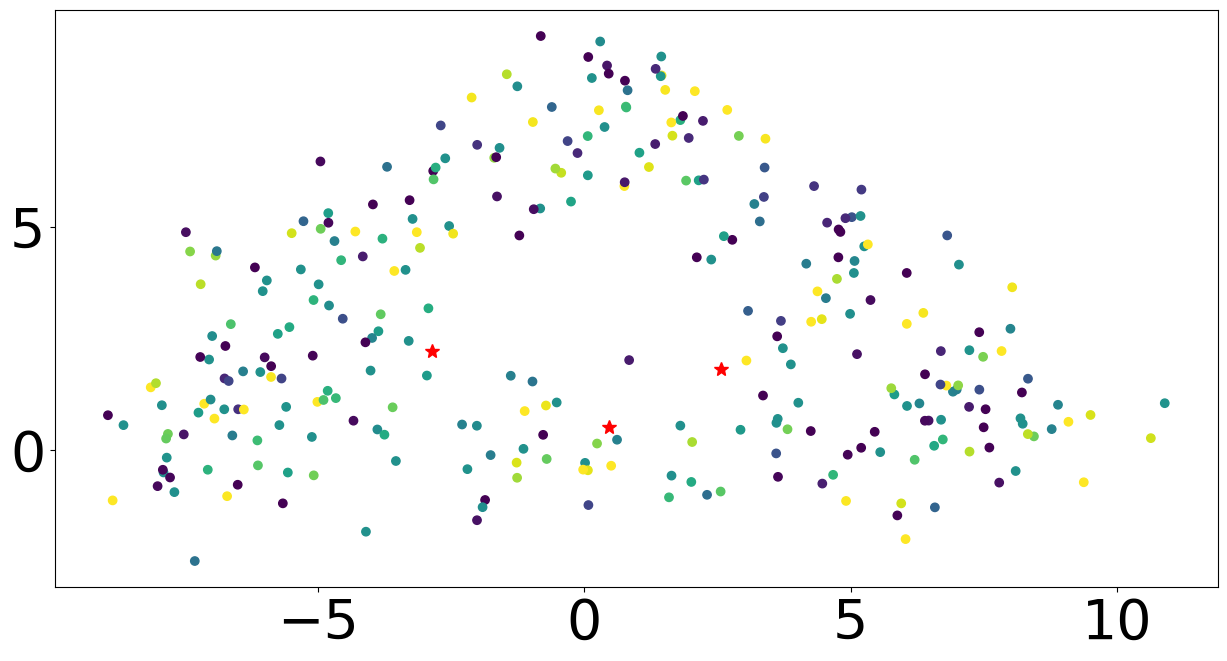

In [277]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.mean(xd_labels,axis=1))
plt.plot(np.mean(mus_wf,axis=2)[:,0],np.mean(mus_wf,axis=2)[:,1],'*r',ms=10)


xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
#for k in range(K):
#    rv = stats.multivariate_normal(np.mean(mus_wf,axis=2)[k,:], np.mean(Sigmas_wf,axis=3)[k,:,:])
#    zz = rv.pdf(data)
#    plt.contour(xx, yy, zz,levels=2,colors='grey')

In [178]:
# mad mix results
aux.pkl_save(madmix_elbos,'../summary/results/madmix_elbos_gmm')
aux.pkl_save(madmix_cput,'../summary/results/madmix_cput_gmm')

# gibbs results
aux.pkl_save(gibbs_cput,'../summary/results/gibbs_cput_gmm')

# mean field results
aux.pkl_save(meanfield_elbos,'../summary/results/meanfield_elbos_gmm')
aux.pkl_save(meanfield_cput,'../summary/results/meanfield_cput_gmm')

# dequantization results
dequant_elbos=np.vstack((dequant_elbos_pg,dequant_elbos_wf))
dequant_cpu_times=np.vstack((dequant_cpu_times_pg,dequant_cpu_times_wf))
aux.pkl_save(dequant_elbos,'../summary/results/dequant_elbos_gmm')
aux.pkl_save(dequant_cput,'../summary/results/dequant_cput_gmm')
aux.pkl_save(dequant_densitycput,'../summary/results/dequant_densitycput_gmm')

# concrete results
concrete_elbos=np.vstack((concrete_elbos_pg,concrete_elbos_wf))
concrete_cpu_times=np.vstack((concrete_pg_cpu_times,concrete_wf_cpu_times))
concrete_densitycput=np.vstack((concrete_densitycput_pg,concrete_densitycput_wf))
aux.pkl_save(concrete_elbos,'../summary/results/concrete_elbos_gmm')
aux.pkl_save(concrete_cpu_times,'../summary/results/concrete_cput_gmm')
aux.pkl_save(concrete_densitycput,'../summary/results/concrete_densitycput_gmm')
#aux.pkl_save(concrete_pg_cput,'../summary/results/concrete_cput_gmm_pg')
#aux.pkl_save(concrete_wf_cput,'../summary/results/concrete_cput_gmm_wf')

NameError: name 'madmix_elbos' is not defined